## Day 27 Lecture 2 Assignment

In this assignment, we will learn about interpreting linear models. We will use the google play store dataset loaded below and analyze the regression from this dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import jarque_bera 
from scipy.stats import normaltest


In [2]:
reviews = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv')
reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


We will predict app ratings using other features describing the app. Recall from the previous assignment our data cleansing steps and do the following:

1. Remove the following columns: app, category, size, installs, genres, last updated, current ver, android ver
2. Convert all columns to numeric and remove rows where this conversion causes null values
3. Split the data into test and train subsets with 25% of the data in the test set

In [3]:
reviews = reviews.drop(columns=['App', 'Category', 'Size', 'Installs', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'])
reviews.dropna(axis=0, inplace=True)
reviews['Price'] = pd.to_numeric(reviews['Price'].str.replace(pat='$',repl=''))
reviews['Type'] = (reviews['Type'] == 'Free').astype(int)
CR_map = {
    'Everyone':1,
    'Everyone 10+':2,
    'Teen':3,
    'Mature 17+':4,
    'Adults only 18+':5,
    'Unrated':6
}
reviews['Content Rating'] = reviews['Content Rating'].replace(CR_map)
reviews['Reviews'] = reviews['Reviews'].astype(int)

In [4]:
X = reviews.drop(columns='Rating')
y = reviews['Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=36
)
X_train = sm.add_constant(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Check model assumptions of homoscedacity, normality of errors, and multicollinearity

In [5]:
model = sm.OLS(y_train, X_train)
results = model.fit()

jb_stats = jarque_bera(results.resid) 
norm_stats = normaltest(results.resid)

_, _, _, p1 = sms.het_breuschpagan(results.resid, X_train)

vifs = [] 
for i in range(X_train.shape[1]): 
    vif = variance_inflation_factor(X_train.values, i) 
    vifs.append(vif)

vifs_results = pd.DataFrame(vifs, index=X_train.columns, columns=['VIFS'])

display(
    p1,
    vifs_results,
    jb_stats,
    norm_stats,
    results.summary()
)

0.00022727949928905565

,VIFS
const,17.185289
Reviews,1.003892
Type,1.054547
Price,1.050969
Content Rating,1.004507


(13563.062867872963, 0.0)

NormaltestResult(statistic=2745.9359500056044, pvalue=0.0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     14.94
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           3.67e-12
Time:                        14:37:32   Log-Likelihood:                -5243.2
No. Observations:                7024   AIC:                         1.050e+04
Df Residuals:                    7019   BIC:                         1.053e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.3112      0.025    170.687      0.000       4.262       4.361
Reviews         1.054e-08   1.86e-09      5.665      0.000     6.9e-09    1.42e-08
Type              -0.1306      0.025     -5.325      0.000      -0.179      -0.082
Price             -0.0010      0.000     -2.353      0.019      -0.002      -0.000
Content Rating    -0.0007      0.007     -0.104      0.918      -0.014       0.013
==============================================================================
Omnibus:                     2745.936   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13563.063
Skew:                          -1.841   Prob(JB):                         0.00
Kurtosis:                       8.726   Cond. No.                     1.87e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using the information above, try to select only the variables you think will lead to a better model and construct that model. Print out a summary

In [6]:
X_train = X_train.drop(columns=['Content Rating'])

In [7]:
model = sm.OLS(y_train, X_train)
results = model.fit()

jb_stats = jarque_bera(results.resid) 
norm_stats = normaltest(results.resid)

_, _, _, p1 = sms.het_breuschpagan(results.resid, X_train)

vifs = [] 
for i in range(X_train.shape[1]): 
    vif = variance_inflation_factor(X_train.values, i) 
    vifs.append(vif)

vifs_results = pd.DataFrame(vifs, index=X_train.columns, columns=['VIFS'])

display(
    p1,
    vifs_results,
    jb_stats,
    norm_stats,
    results.summary()
)

0.06643211669427888

,VIFS
const,15.056949
Reviews,1.001810
Type,1.052647
Price,1.050841


(13555.00541718779, 0.0)

NormaltestResult(statistic=2745.1683163881307, pvalue=0.0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     19.92
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           7.50e-13
Time:                        14:37:32   Log-Likelihood:                -5243.2
No. Observations:                7024   AIC:                         1.049e+04
Df Residuals:                    7020   BIC:                         1.052e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3102      0.024    182.326      0.000       4.264       4.357
Reviews     1.054e-08   1.86e-09      5.666      0.000    6.89e-09    1.42e-08
Type          -0.1307      0.024     -5.335      0.000      -0.179      -0.083
Price         -0.0010      0.000     -2.352      0.019      -0.002      -0.000
==============================================================================
Omnibus:                     2745.168   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13555.005
Skew:                          -1.840   Prob(JB):                         0.00
Kurtosis:                       8.725   Cond. No.                     1.84e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Plot the scatterplots between the independent variables you select and ratings. Do you think given this graph, these variables have good predictive power? 

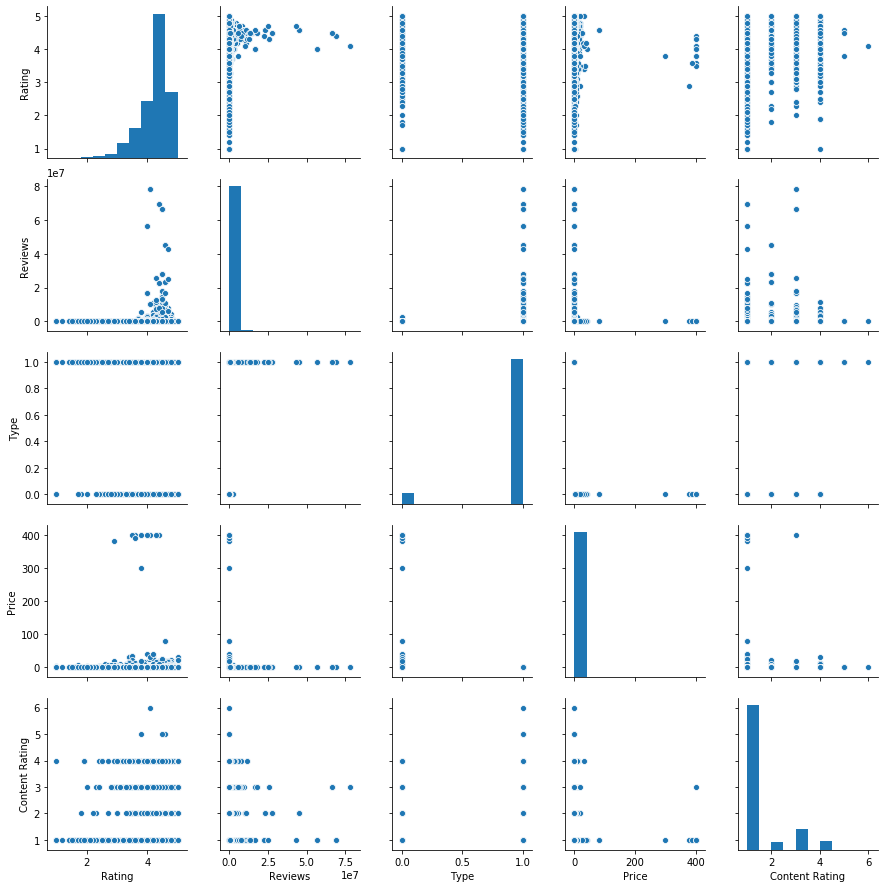

In [8]:
sns.pairplot(reviews)
plt.show()